# Idealized Case 3: Brownian Motion of Cells 

This tutorial shows the most important steps of tracking with `tobac` using an idealized case:

1. [Input Data](#1.-Input-Data)
2. [Feature Detection](#2.-Feature-Detection)
3. [Tracking / Trajectory Linking](#3.-Trajectory-Linking)
4. [Segmentation](#4.-Segmentation)
5. [Statistical Analysis](#5.-Statistical-Analysis)

In [3]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import seaborn as sns

sns.set_context("talk")
np.random.seed(12345)

In [8]:
x_min, y_min, x_max, y_max, = 0, 0, 10, 10
t_min, t_max = 0, 100

x = np.linspace(x_min, x_max, 200)
y = np.linspace(y_min, y_max, 200)
t = np.linspace(t_min, t_max, 100)

tt, yy, xx = np.meshgrid(t, y, x, indexing='ij')

In [9]:
tt.shape

(100, 200, 200)

In [10]:
yy.shape

(100, 200, 200)

In [21]:
def create_wandering_blob(x_0, y_0, t_create=t_min, t_vanish=t_max, sigma=0.2):
    
    x = x_0
    y = y_0
    
    pos_list = [(x_0, y_0)]
    
    for i in range(len(tt)):
        ds = np.random.random()
        angle = np.random.random()*2*np.pi
        dx = ds*np.cos(angle)
        dy = ds*np.sin(angle)
        x+=dx
        y+=dy
        pos_list.append((x, y))
    
    exponent = (xx - x_0 - v_x*(tt-t_create))**2 + (yy - y_0 - v_y*(tt-t_create))**2
    #feature_alive = np.logical_and(tt>=t_create , tt<=t_vanish)
    #blob = np.where(feature_alive, np.exp(-exponent/sigma), 0)
    
    return pos_list

def create_xarray(array):

    t_0 = np.datetime64('2022-04-01T00:00')
    t_delta = np.timedelta64(1, 'm')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y
             }
    
    attributes = {'units': ('m s-1')}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

In [22]:
create_wandering_blob(5, 5)

NameError: name 'v_x' is not defined

In [2]:
for i in range(100):
    
    x_0 = np.random.random()*10
    y_0 = np.random.random()*10
    v_x = np.random.random()*0.1 - 0.05
    v_y = np.random.random()*0.1 - 0.05
    t_min = 0
    t_max = np.random.random()*(10-t_min) + t_min
    sigma = np.random.random()*0.1
    
    if i == 0:
        blob = create_wandering_blob(x_0, y_0, v_x, v_y, t_min, t_max, sigma)
    else:
        blob += create_wandering_blob(x_0, y_0, v_x, v_y, t_min, t_max, sigma)
        
data = create_xarray(blob)

<IPython.core.display.Javascript object>


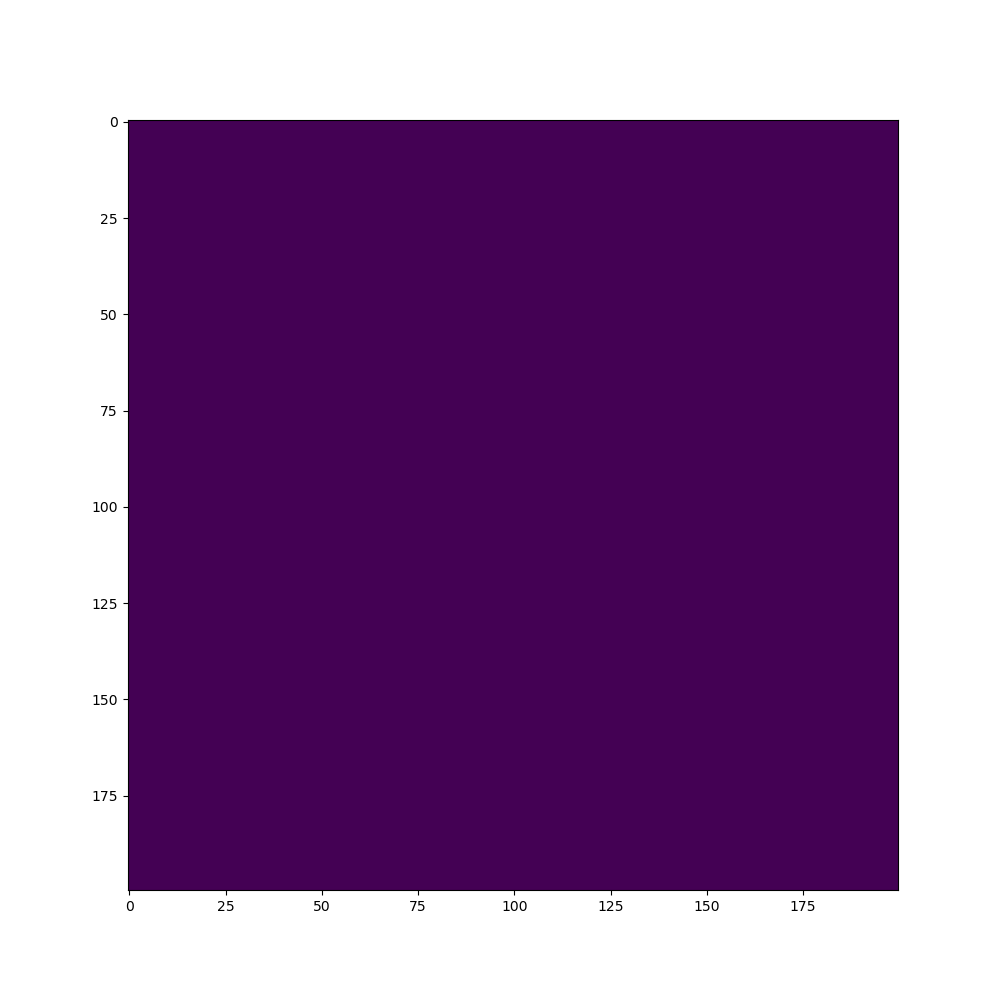

In [3]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots(figsize = (10, 10))

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 50)

Frame 3: 23 trajectories present.


Text(0.5, 1.0, 'predict')

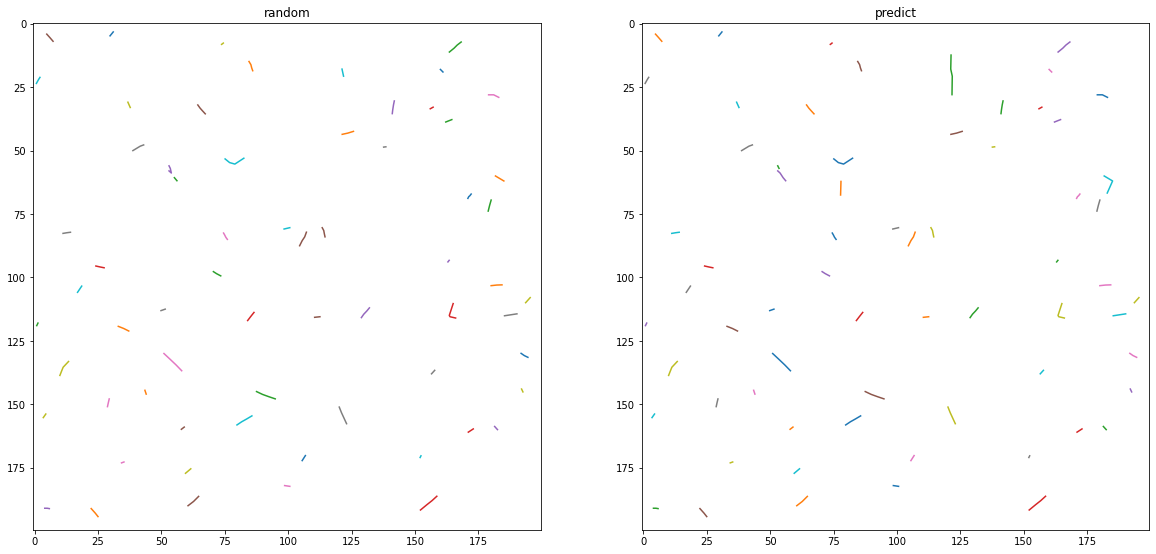

In [4]:
%matplotlib inline

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/50)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.7)
#mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.3)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1,
                                              method_linking='random',
                                              subnetwork_size=30)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=2, 
                                              method_linking='predict',
                                              subnetwork_size=30)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.imshow(blob[0], cmap = 'Greys', alpha = 0)
ax2.imshow(blob[0], cmap = 'Greys', alpha = 0)

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-') 
#ax1.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax2.set_title('predict')